In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path|
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

In [2]:
class setup:
    R = 3.50 # Ом, добавочное сопротивление (указано на установке)
    C_low = 33.2
    C_high = 68
    
def t_coeff(n):
    '''
    Returns t-test coefficient
    n -- number of points
    '''
    assert n > 0, 'n must be positive'
    __students = [12.7062, 4.3027, 3.1824, 2.7764, 2.5706, 2.4469, 2.3646, 2.3060, 2.2622]
    if n < len(__students):
        return __students[n-1]
    else:
        return 2

In [44]:
data = mipt.read_excel('data/322.xlsx', usecols=range(13), header=(0,1)).dropna()
data

C       f0    Uc    E    low                                high  \
    24.8    32190  5.18  0.2      f     Uc    x     x0     dF/pi      f   
0   33.2  27850.0  4.56  0.2  26400  1.720  2.5  25.75  0.097087  18000   
1   47.6  23270.0  3.94  0.2  26600  1.935  3.0  25.75  0.116505  18200   
2   57.5  21160.0  3.65  0.2  26800  2.220  4.0  25.75  0.155340  18400   
3   68.0  19460.0  3.39  0.2  27000  2.635  5.0  25.75  0.194175  18600   
4  102.8  15840.0  2.83  0.2  27200  3.110  6.0  25.75  0.233010  18800   

                   
      Uc    x  x0  
0  1.230  3.5  37  
1  1.405  4.0  37  
2  1.605  5.0  37  
3  1.875  6.0  37  
4  2.235  8.0  37

## Запускать все ячейки последовательно и равномерно...

# Таблица результатов

In [50]:
U = data['Uc'].to_numpy().flatten()
E = data['E'].to_numpy().flatten()
C = data['C'].to_numpy().flatten() # нФ
f = data['f0'].to_numpy().flatten() # Гц

serror = 0.05 / C[0] # -- Погрешность емкости будет влиять 
                     # на полную погрешность индуктивности, берем макс, для оценки

#
# Все значение посчитаны при резонансе...
#
L = 1/((2 * math.pi * f)**2 * C * 1e-9) * 1e6 # мкГн -- индуктивность
rho = 2 * math.pi * f * L * 1e-6 # Ом -- волновое сопротивление контура 
Q = U / E # -- добротность контура
Rsum = rho / Q # Ом -- суммарное сопротивление Rsum = Rs + RL + R (R -- на установке)
Rs = rho * 1e-3 # Ом -- эквивалентное последовательное сопротивление (ЭПС) конденсатора 
RL = Rsum - Rs - setup.R # Ом -- сопротивление катушки
I = E / Rsum # А -- ток через установку (тут другого тока нет)

results_list = {
    'C' : C,
    'f' : f,
    'U' : U,
    'E' : E,
    'L' : L,
    'Q' : Q,
    'rho' : rho,
    'Rsum' : Rsum,
    'RL' : RL,
    'I' : I
}

results_fmt = {
    'C': [r'$C$, нФ', '{:.1f}'],
    'f' :  [r'$f_0$, Гц', '{:.0f}'],
    'U' :  [r'$U_C$, В', '{:.2f}'],
    'E' :  [r'$\mathscr{E}$, В', '{:.1f}'],
    'L' :  [r'$L$, мкГн', '{:.1f}'],
    'Q' :  [r'$\mathcal{Q}$', '{:.1f}'],
    'rho' :  [r'$\rho$, Ом', '{:.1f}'],
    'Rsum' :  [r'$R_{\Sigma}, Ом$', '{:.1f}'],
    'RL' :  [r'$R_L$, Ом', '{:.1f}'],
    'I' :  [r'$I$, А', '{:.3f}'],
}

L_error = t_coeff(L.size) * L.std() / (L.size)**0.5
RL_error = t_coeff(RL.size) * RL.std() / (RL.size)**0.5
mean_list = {
    'names' : ['$L$, мкГн', '$R_L$, Ом'],
    'mean' : [L.mean(), RL.mean()],
    'std' : [L.std(), RL.std()],
    'error' : [L_error, RL_error],
    'serror' : [(L_error**2 + (L.mean()*serror)**2)**0.5, (RL_error**2 + (RL.mean()*serror)**2)**0.5],
}

RL_full_error = (RL_error**2 + (RL.mean()*serror)**2)**0.5

mean_fmt = {
    'names' :  [r''],
    'mean' :  [r'Среднее значение', '{:.1f}'],
    'std' :  [r'Среднеквадратичное', '{:.1f}'],
    'error' :  [r'Случайная погрешность', '{:.1f}'],
    'serror' :  [r'Погрешность', '{:.1f}'],
}

results = pd.DataFrame(results_list)
tab = mipt.table(results, results_fmt)
tab.to_latex('gen/setup.tex')
tab.rename().data

mean = pd.DataFrame(mean_list)
mean_tab = mipt.table(mean, mean_fmt)
mean_tab.to_latex('gen/setup-mean.tex')
mean_tab.rename().data
tab.rename().data

,"$C$, нФ","$f_0$, Гц","$U_C$, В","$\mathscr{E}$, В","$L$, мкГн",$\mathcal{Q}$,"$\rho$, Ом","$R_{\Sigma}, Ом$","$R_L$, Ом","$I$, А"
0,33.2,27850.0,4.56,0.2,983.675332,22.80,172.130111,7.549566,3.877436,0.026492
1,47.6,23270.0,3.94,0.2,982.744324,19.70,143.686774,7.293745,3.650058,0.027421
2,57.5,21160.0,3.65,0.2,983.877643,18.25,130.808698,7.167600,3.536791,0.027903
3,68.0,19460.0,3.39,0.2,983.661511,16.95,120.273066,7.095756,3.475483,0.028186
4,102.8,15840.0,2.83,0.2,982.057223,14.15,97.739889,6.907413,3.309673,0.028954


# Амплитудно-частотные характеристики

Я считал для двух значений. Меньшее -- low, большее -- high

C = 33.2 нФ резонанс = 27805 Гц
C =   68 нФ резонанс = 19427 Гц


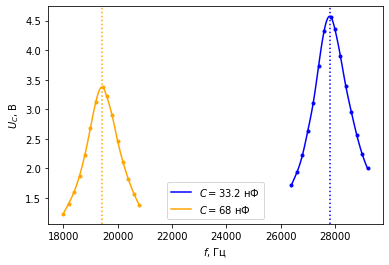

In [30]:
data = mipt.read_excel('data/322.xlsx', usecols=range(4,14), header=(0,1)).dropna()
data

fmt = {
    'low' : [r'$C={0}$ нФ'.format(setup.C_low), '{:.1f}'],
    'high' : [r'$C={0}$ нФ'.format(setup.C_high), '{:.1f}'],
    ('high', 'f') :  [r'$f_0$, Гц', '{:.0f}'],
    ('high', 'Uc') :  [r'$U_C$, В', '{:.2f}'],
    ('high', 'x') :  [r'$x$, дел.', '{:.1f}'],
    ('high', 'x0') :  [r'$x_0$, дел.', '{:.1f}'],
    ('high', 'dF/pi') :  [r'$\frac{\varphi}{\pi}$, дел.', '{:.2f}'],
    ('low', 'f') :  [r'$f_0$, Гц', '{:.0f}'],
    ('low', 'Uc') :  [r'$U_C$, В', '{:.2f}'],
    ('low', 'x') :  [r'$x$, дел.', '{:.1f}'],
    ('low', 'x0') :  [r'$x_0$, дел.', '{:.1f}'],
    ('low', 'dF/pi') :  [r'$\frac{\varphi}{\pi}$, дел.', '{:.2f}'],
}

tab = mipt.table(data, fmt)
tab.to_latex('gen/measure.tex')

tab.rename().data

low = data['low']
high = data['high']

from scipy.interpolate import interp1d
def interp(x, y):
    return interp1d(x, y, kind='cubic')
    
x, y, equ_low = mipt.plot(low['f'], low['Uc'], func=interp, color='blue', label=r'$C={0}$ нФ'.format(setup.C_low))
x, y, equ_high = mipt.plot(high['f'], high['Uc'], func=interp, color='orange', label=r'$C={0}$ нФ'.format(setup.C_high))

low_resonance = op.fmin(lambda x: -equ_low(x), low['f'][0], disp=0)[0]
high_resonance = op.fmin(lambda x: -equ_high(x), high['f'][0], disp=0)[0]

plt.axvline(x=low_resonance, c='blue', ls=':')
plt.axvline(x=high_resonance, c='orange', ls=':')

plt.ylabel(r"$U_C$, В")
plt.xlabel(r"$f$, Гц")
plt.legend()
plt.savefig('gen/fig-resonance.pdf')

print('C = {:4} нФ резонанс = {:.0f} Гц'.format(setup.C_low, low_resonance))
print('C = {:4} нФ резонанс = {:.0f} Гц'.format(setup.C_high, high_resonance))

# Амплитудно-частотные характеристики в безразмерных координатах

C = 33.2 нФ 
ширина = 1.0224 - 0.9781 = 0.0443
Q = 22.57870818478546 +- 0.4515741636957092
C =   68 нФ 
ширина = 1.0300 - 0.9697 = 0.0603
Q = 16.5711552304821 +- 0.33142310460964197


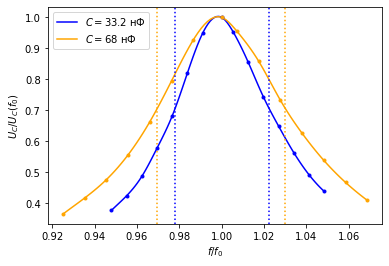

In [31]:
# Warning! Нужно запустить предыдущую ячейку чтоб тут была функции интерполяции equ_low и equ_high

data = mipt.read_excel('data/322.xlsx', usecols=range(4,14), header=(0,1)).dropna()
settings = mipt.read_excel('data/322.xlsx', usecols=range(0,4), header=(0)).dropna()
low = data['low']
high = data['high']

# Вычленим резонансные частоты
f0_low  = settings['f0'].tolist()[settings.index[settings['C'] == setup.C_low ].tolist()[0]]
f0_high = settings['f0'].tolist()[settings.index[settings['C'] == setup.C_high].tolist()[0]]

x_low = low['f']/f0_low
x_high = high['f']/f0_high

y_low = equ_low(low['f']) / equ_low(f0_low)
y_high = equ_high(high['f']) / equ_high(f0_high)

x, y, norm_low = mipt.plot(x_low, y_low, func=interp, color='blue', label=r'$C={0}$ нФ'.format(setup.C_low))
x, y, norm_high = mipt.plot(x_high, y_high, func=interp, color='orange',label=r'$C={0}$ нФ'.format(setup.C_high))

low_right = op.fsolve(lambda x: norm_low(x) - 0.707, 1.01)[0]
low_left = op.fsolve(lambda x: norm_low(x) - 0.707, 0.99)[0]

high_right = op.fsolve(lambda x: norm_high(x) - 0.707, 1.01)[0]
high_left = op.fsolve(lambda x: norm_high(x) - 0.707, 0.99)[0]

plt.axvline(x=low_right, c='blue', ls=':')
plt.axvline(x=low_left, c='blue', ls=':')

plt.axvline(x=high_right, c='orange', ls=':')
plt.axvline(x=high_left, c='orange', ls=':')

plt.ylabel(r"$U_C/U_C(f_0)$")
plt.xlabel(r"$f/f_0$")
plt.legend()
plt.savefig('gen/fig-resonance-norm.pdf')


Q_low = 1 / (low_right - low_left)
Q_high = 1 / (high_right - high_left)

print('C = {:4} нФ \nширина = {:.4f} - {:.4f} = {:.4f}'.format(setup.C_low, low_right, low_left, low_right - low_left))
print('Q = {} +- {}'.format(Q_low, 2e-2 * Q_low))

print('C = {:4} нФ \nширина = {:.4f} - {:.4f} = {:.4f}'.format(setup.C_high, high_right, high_left, high_right - high_left))
print('Q = {} +- {}'.format(Q_high, 2e-2 * Q_high))

# Фазово-частотные характеристики 

In [32]:
# Warning! Нужно запустить предыдущую ячейку

C = 33.2 нФ 
ширина = 1.0253 - 0.9770 = 0.0484
Q = 20.6724631979196 +- 0.40298119769026586
C =   68 нФ 
ширина = 1.0388 - 0.9697 = 0.0692
Q = 14.455377725814989 +- 0.1953429422407431


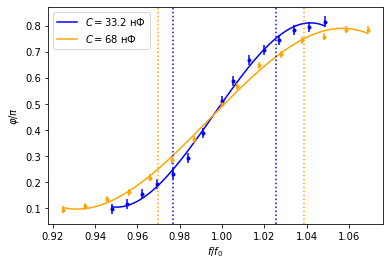

In [42]:
phi_low  = low['dF/pi']
phi_high = high['dF/pi']

from scipy.interpolate import UnivariateSpline
def interp(x, y):
    return UnivariateSpline(x, y, s=0.1)

x, y, fphi_low = mipt.plot(x_low, phi_low, yerr = phi_low * 0.5 / low['x'], func=interp, color='blue', label=r'$C={0}$ нФ'.format(setup.C_low))
x, y, fphi_high = mipt.plot(x_high, phi_high, yerr = phi_high * 0.5 / high['x'], func=interp, color='orange',label=r'$C={0}$ нФ'.format(setup.C_high))

low_right = op.fsolve(lambda x: fphi_low(x) - 3/4, 1)[0]
low_left = op.fsolve(lambda x: fphi_low(x) - 1/4, 1)[0]

high_right = op.fsolve(lambda x: fphi_high(x) - 3/4, 1)[0]
high_left = op.fsolve(lambda x: fphi_high(x) - 1/4, 1)[0]

plt.axvline(x=low_right, c='blue', ls=':')
plt.axvline(x=low_left, c='blue', ls=':')

plt.axvline(x=high_right, c='orange', ls=':')
plt.axvline(x=high_left, c='orange', ls=':')

Q_low = 1 / (low_right - low_left)
Q_high = 1 / (high_right - high_left)

plt.ylabel(r"$\varphi/\pi$")
plt.xlabel(r"$f/f_0$")
plt.legend()
plt.savefig('gen/fig-phase.pdf')

print('C = {:4} нФ \nширина = {:.4f} - {:.4f} = {:.4f}'.format(setup.C_low, low_right, low_left, low_right - low_left))
print('Q = {} +- {}'.format(Q_low, (phi_low * 0.5 / low['x']).mean() * Q_low))

print('C = {:4} нФ \nширина = {:.4f} - {:.4f} = {:.4f}'.format(setup.C_high, high_right, high_left, high_right - high_left))
print('Q = {} +- {}'.format(Q_high, (phi_high * 0.5 / high['x']).mean() * Q_high))

# Постройте зависимость 𝑅𝐿(𝜈0𝑛) в системе координат с началом в точке (0,6𝜈07; 0);

Text(0.5, 0, '$f$, Гц')

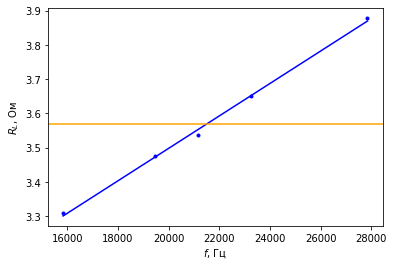

In [90]:
# Я на эту фигню подзабил, но при желании -- сохраняй

mipt.plot(f, RL, color='blue')
plt.axhline(y=RL.mean(), color='orange')

plt.ylabel(r"$R_L$, Ом")
plt.xlabel(r"$f$, Гц")
# plt.savefig('gen/fig-rl.pdf') <-- Delete comment here